# PXD022545
## Proteomic analysis of ARPE-19 cells exposed to chronic H2O2 treatment
[PRIDE link](https://www.ebi.ac.uk/pride/archive/projects/PXD022545)

[Article link](https://www.mdpi.com/2076-3921/10/1/25)

In [1]:
#Import libraries
os.chdir("/home/robbe/ionbot/")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import re
import numpy as np
import os
from pathlib import Path
from pyteomics import mass as pymass
import OxiAnalysis


db = pymass.Unimod()
modslist = []
for p in range(len(db.mods)):
    for pp in db.mods[p]['specificity']:
        if db.mods[p]['record_id'] in [35, 53, 129, 130, 205, 206, 275, 288, 318, 319, 335, 340, 342, 344, 345, 348, 349, 350, 351, 352, 354, 
        359, 360, 368, 378, 392, 401, 421, 425, 534, 540, 548, 569, 720, 721, 743, 743, 860, 936, 936, 937, 949, 1384, 1914, 1915, 1916, 1917, 1918, 
        1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929]:
            t = db.mods[p]['title']
            t = t.replace("[",":").replace("]",":")
            mod = "[" + str(db.mods[p]['record_id']) + "]" + t + "[" + pp['site'] + "]"
            modslist.append(mod)
modslist.append('[35]oxidation[M]')

In [2]:
first = pd.read_csv("/home/robbe/ionbot/full_projects/PXD022545_first.csv", index_col=0)
del first["Unnamed: 0"]
del first["Unnamed: 0.1"]
del first["spectrum_title"]
del first["scan"]
first['modifications'] = first['modifications'].fillna("None")
first['Oxidant treatment'] = first['Oxidant treatment'].fillna("None")
first['Secondary treatment'] = first['Secondary treatment'].fillna("None")
first['Length of Secondary treatment (mins)'] = first['Length of Secondary treatment (mins)'].fillna(0)
first['Length of oxidant treatment (mins)'] = first['Length of oxidant treatment (mins)'].replace('0', 0)

/tmp/ipykernel_2795897/4217098548.py:1: DtypeWarning: Columns (25,29) have mixed types. Specify dtype option on import or set low_memory=False.
  first = pd.read_csv("/home/robbe/ionbot/full_projects/PXD022545_first.csv", index_col=0)


In [3]:
first.head()

,ionbot_match_id,spectrum_file,precursor_mass,peptide_mass,observed_retention_time,charge,database_peptide,matched_peptide,modifications,modifications_delta,...,Organism,Cell line,Oxidant treatment,Oxidant dose (µM),Secondary treatment,Secondary treatment dose (µM),Length of oxidant treatment (mins),Length of Secondary treatment (mins),Notes,First/Lower/Coeluting
0,0_8_1,2020-07-14_MS_PG_Proteome_Davide_Casserini_CTR...,790.34769,7903.4568,0.88133,2,EAADTER,EAADTER,None,0|,...,Human,ARPE-19,None,0,None,0.0,0,0.0,NaN,First
1,0_7572_1,2020-07-14_MS_PG_Proteome_Davide_Casserini_CTR...,1911.78352,19117.8054,1163.81700,4,SEEAHAEDSVMDHHFR,SEEAHAEDSVMDHHFR,11|[35]oxidation[M],11|15.9949,...,Human,ARPE-19,None,0,None,0.0,0,0.0,NaN,First
2,0_7573_4,2020-07-14_MS_PG_Proteome_Davide_Casserini_CTR...,762.36667,7623.6603,1163.86404,2,GTFPDAR,GTFPDAR,None,0|,...,Human,ARPE-19,None,0,None,0.0,0,0.0,NaN,First
3,0_7574_2,2020-07-14_MS_PG_Proteome_Davide_Casserini_CTR...,939.45005,9394.4836,1163.91264,2,VMEYINR,VMEYINR,2|[35]oxidation[M],2|15.9949,...,Human,ARPE-19,None,0,None,0.0,0,0.0,NaN,First
4,0_7575_1,2020-07-14_MS_PG_Proteome_Davide_Casserini_CTR...,895.40507,8954.0354,1164.25452,2,ESFDGSVR,ESFDGSVR,None,0|,...,Human,ARPE-19,None,0,None,0.0,0,0.0,NaN,First


In [4]:
print("The amount of PSMs in this project dataset is: ", first.shape[0])
print("The amount of raw files that make up the master dataset is: ", len(first["spectrum_file"].unique()))

The amount of PSMs in this project dataset is:  110369
The amount of raw files that make up the master dataset is:  6


In [5]:
os.chdir("/home/robbe/ionbot")

In [66]:
#Figure out how to put these in OxiAnalysis
def get_positions(str):
    if str == "None":
        return None
    if str != "":
        lijst = str.split("|")
        result = lijst[0::2]
        if len(result) == 1:
            return result[0]
        else:
            return result

def get_modification(str):
    if str == "None":
        return None
    lijst = str.split("|")
    if len(lijst) <= 1:
        return None
    else:
        result = lijst[1::2]
        if len(result) == 1:
            return result[0]
        else:
            return result

def oxidatively_modified(str):
    for mod in modslist:
        if mod in str:
            return True
        else:
            continue
    return False




In [67]:
first['Peptidoform_name'] = first.apply(lambda row: OxiAnalysis.peptidoform_name(row), axis=1)
first['Position'] = first['modifications'].apply(get_positions)
first['Modification'] = first['modifications'].apply(get_modification)
first['Oxidatively_modified'] = first['modifications'].apply(oxidatively_modified)

## Overview of the treatments in this project

In [8]:
first.groupby(["Oxidant treatment", "Oxidant dose (µM)", "Length of oxidant treatment (mins)", "Secondary treatment", "Secondary treatment dose (µM)", 'Length of Secondary treatment (mins)'])["ionbot_match_id"].count().to_frame().reset_index()

,Oxidant treatment,Oxidant dose (µM),Length of oxidant treatment (mins),Secondary treatment,Secondary treatment dose (µM),Length of Secondary treatment (mins),ionbot_match_id
0,H2O2,10,Chronic,None,0.0,0.0,26770
1,None,0,0,None,0.0,0.0,72283


## Comparison between the treatments


In [9]:
H2O2 = first.loc[lambda first: first["Oxidant treatment"] == "H2O2"]
Control = first.loc[lambda first: first["Oxidant treatment"] == "None"]
print("There are this many replicates of each treatment: {}".format(H2O2["spectrum_file"].nunique()))

There are this many replicates of each treatment: 3


In [10]:
#Filters PSMs found in all replicates (figure out how to put this one in OxiAnalysis)
def replicate_filter(df, n_of_replicates):
    return df[df.groupby("Peptidoform_name")["spectrum_file"].transform('nunique') == n_of_replicates]

In [11]:
H2O2rep = replicate_filter(H2O2, 3)
Controlrep = replicate_filter(Control, 3)

### Oxidatively modified PSMs

In [12]:
print("The ratio of PSMs that contain an oxidative modification in the H2O2 treatment subset: {}".format((H2O2rep['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))
print("The ratio of PSMs that contain an oxidative modification in the Control treatment subset: {}".format((Controlrep['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))

The ratio of PSMs that contain an oxidative modification in the H2O2 treatment subset: 19.399372478709097 %
The ratio of PSMs that contain an oxidative modification in the Control treatment subset: 19.866187473158384 %


There is barely any difference between the ratio of oxidized PSMs between the treatment and control set-ups.

In [14]:
#Makes modratios file of occurence of PTM/total PSMs (figure out how to put this in OxiAnalysis)
def modratios(df):
    peptidoforms = df["Modification"]
    Modification = []
    Ratios = []
    for mod in modslist:
        Modification.append(mod)
        val = 0
        total = 0
        for i, peptidoform in peptidoforms.items():
            if peptidoform == None:
                total += 1
                continue
            elif mod in peptidoform:
                total += 1
                val += 1
        Ratios.append(val/total)
    dt = {"Modification" : Modification, "Ratios" : Ratios}
    result = pd.DataFrame(dt)
    return result


In [15]:
mrH2O2rep = modratios(H2O2rep)
mrControlrep = modratios(Controlrep)

In [87]:
modr = pd.merge(mrH2O2rep,mrControlrep, on="Modification", suffixes=('_H2O2', '_Control'))
modr["Difference"] = modr["Ratios_H2O2"] - modr["Ratios_Control"]
modr = modr.drop(modr[(modr["Ratios_H2O2"] == 0) & (modr["Ratios_Control"] == 0)].index)
modr


,Modification,Ratios_H2O2,Ratios_Control,Difference
0,[35]Oxidation[T],0.000538,0.000366,0.000172
1,[35]Oxidation[E],0.001135,0.001278,-0.000144
2,[35]Oxidation[S],0.000538,0.000670,-0.000132
3,[35]Oxidation[Q],0.000120,0.000731,-0.000611
5,[35]Oxidation[I],0.000538,0.000883,-0.000345
7,[35]Oxidation[G],0.000000,0.000457,-0.000457
8,[35]Oxidation[W],0.001731,0.001370,0.000361
10,[35]Oxidation[H],0.000000,0.000061,-0.000061
11,[35]Oxidation[V],0.000418,0.000335,0.000083
12,[35]Oxidation[R],0.000359,0.000305,0.000054


,Modification,Ratios_H2O2,Ratios_Control,Difference
0,[35]Oxidation[T],0.000538,0.000366,0.000172
1,[35]Oxidation[E],0.001135,0.001278,-0.000144
2,[35]Oxidation[S],0.000538,0.000670,-0.000132
3,[35]Oxidation[Q],0.000120,0.000731,-0.000611
5,[35]Oxidation[I],0.000538,0.000883,-0.000345
7,[35]Oxidation[G],0.000000,0.000457,-0.000457
8,[35]Oxidation[W],0.001731,0.001370,0.000361
10,[35]Oxidation[H],0.000000,0.000061,-0.000061
11,[35]Oxidation[V],0.000418,0.000335,0.000083
12,[35]Oxidation[R],0.000359,0.000305,0.000054


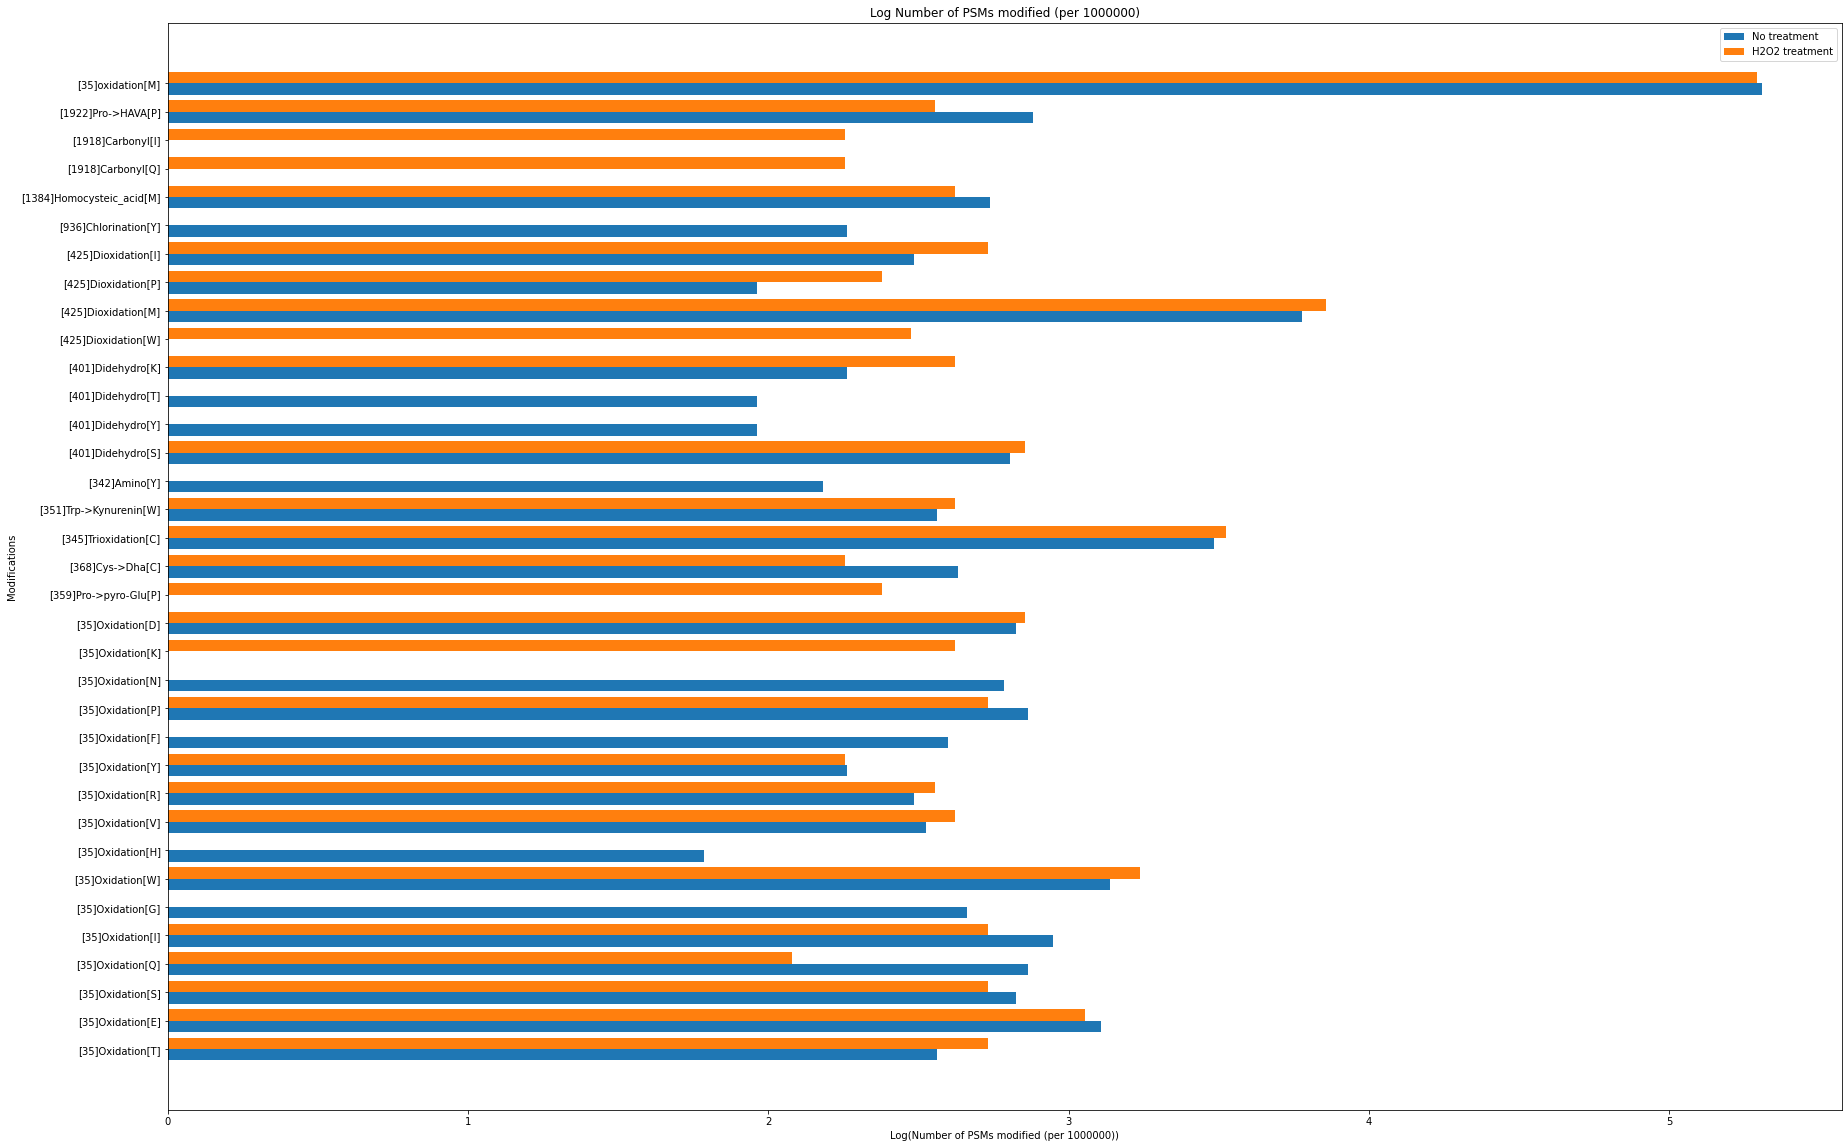

In [86]:
y = modr["Modification"]
xnone = np.log10(modr['Ratios_Control']*1000000)
xH = np.log10(modr['Ratios_H2O2']*1000000)
y_axis = np.arange(len(y))

plt.figure(figsize=(30,20))
plt.barh(y_axis - 0.2, xnone, 0.4, label = 'No treatment')
plt.barh(y_axis + 0.2, xH, 0.4, label = 'H2O2 treatment')

plt.yticks(y_axis, y)
plt.ylabel("Modifications")
plt.xlabel("Log(Number of PSMs modified (per 1000000))")
plt.title("Log Number of PSMs modified (per 1000000)")

plt.legend()
plt.show()

In [68]:
#Makes Venn diagram of shared and non-shared peptidoforms (figure out how to put this in OxiAnalysis)
def condition_venn(listofdf, listoflabels):
    import matplotlib_venn as venn
    setlist = []
    for df in listofdf:
        s = set(df["Peptidoform_name"])
        setlist.append(s)
    total = len(set().union(*setlist))
    plt.figure(figsize=(10,10))
    diagram = venn.venn2(setlist, set_labels=listoflabels, subset_label_formatter=lambda x: f"{(x/total):1.0%}")
    return diagram

def comparelist(treatment_df, control_df):
    treatmentset = set(treatment_df["Peptidoform_name"])
    controlset = set(control_df["Peptidoform_name"])
    diffset = treatmentset - controlset
    difflist = list(diffset)
    diffdf = treatment_df[treatment_df['Peptidoform_name'].isin(difflist)]
    return difflist, diffdf


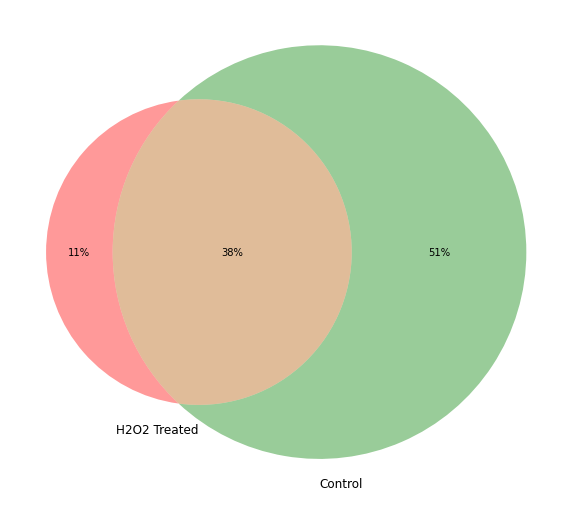

In [69]:
condition_venn([H2O2rep, Controlrep], ["H2O2 Treated", "Control"])

In [21]:
difflist, pf_only_treatment = comparelist(H2O2rep,Controlrep)
pf_only_treatment

,ionbot_match_id,spectrum_file,precursor_mass,peptide_mass,observed_retention_time,charge,database_peptide,matched_peptide,modifications,modifications_delta,...,Secondary treatment,Secondary treatment dose (µM),Length of oxidant treatment (mins),Length of Secondary treatment (mins),Notes,First/Lower/Coeluting,Peptidoform_name,Position,Modification,Oxidatively_modified
72284,0_7331_3,2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O...,757.44523,7574.4460,1250.76810,2,AGIIASAR,AGIIASAR,None,0|,...,None,NaN,Chronic,0.0,NaN,First,AGIIASAR,None,None,False
72299,0_7402_4,2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O...,946.45188,9464.5083,1258.52490,2,VTEQEWR,VTEQEWR,None,0|,...,None,NaN,Chronic,0.0,NaN,First,VTEQEWR,None,None,False
72304,0_7421_1,2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O...,928.45048,9284.5014,1260.39528,2,GEGPEVDVK,GEGPEVDVK,None,0|,...,None,NaN,Chronic,0.0,NaN,First,GEGPEVDVK,None,None,False
72316,0_7493_1,2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O...,1045.50596,10455.0396,1269.82716,2,SIAAEEEAAR,SIAAEEEAAR,None,0|,...,None,NaN,Chronic,0.0,NaN,First,SIAAEEEAAR,None,None,False
72325,0_7530_1,2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O...,830.45029,8304.4976,1276.33254,2,EIAIGSNK,EIAIGSNK,None,0|,...,None,NaN,Chronic,0.0,NaN,First,EIAIGSNK,None,None,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110354,0_7345_1,2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O...,1085.57322,10855.7167,1207.30890,2,VAQPTITDNK,VAQPTITDNK,None,0|,...,None,0.0,Chronic,0.0,NaN,First,VAQPTITDNK,None,None,False
110360,0_7367_1,2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O...,757.35081,7574.4460,1211.11392,2,AGIIASAR,AGIIASAR,None,0|,...,None,0.0,Chronic,0.0,NaN,First,AGIIASAR,None,None,False
110362,0_7379_3,2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O...,757.44541,7574.4460,1213.03350,2,AGIIASAR,AGIIASAR,None,0|,...,None,0.0,Chronic,0.0,NaN,First,AGIIASAR,None,None,False
110364,0_7389_1,2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O...,828.34879,8274.3886,1214.16228,2,ATIPSPDK,ATIPSPDK,None,0|,...,None,0.0,Chronic,0.0,NaN,First,ATIPSPDK,None,None,False


In [22]:
#Makes modcounts file of how many PTM occurs in PSM df (figure out how to put this in OxiAnalysis)
def modcounts(df):
    peptidoforms = df["Modification"]
    Modification = []
    countlist = []
    for mod in modslist:
        Modification.append(mod)
        val = 0
        for i, peptidoform in peptidoforms.items():
            if peptidoform == None:
                continue
            elif mod in peptidoform:
                val += 1
        countlist.append(val)
    dt = {"Modification" : Modification, "Counts" : countlist}
    result = pd.DataFrame(dt)
    return result


In [23]:
onlytreatment = modcounts(pf_only_treatment)
onlytreatment = onlytreatment.sort_values("Counts", ascending=False).drop(onlytreatment[onlytreatment["Counts"] == 0].index, axis=0)

In [24]:
onlytreatment

,Modification,Counts
129,[35]oxidation[M],559
80,[425]Dioxidation[M],21
33,[345]Trioxidation[C],20
19,[35]Oxidation[D],9
18,[35]Oxidation[K],7
12,[35]Oxidation[R],6
77,[425]Dioxidation[W],5
83,[425]Dioxidation[P],4
38,[351]Trp->Kynurenin[W],4
25,[359]Pro->pyro-Glu[P],4


In [26]:
#Gives relative level of PSMs containing unmodified residues (figure out how to put this in OxiAnalysis)
def relative_PSM_modification(df):
    amino_acids = ["A","R","N","D","C","Q","E","G","H","I","K","M","F","P","S","T","W","Y","V"] #No L because L not found ==> I = I/L
    ratiolist = []
    for aa in amino_acids:
        filtered = df[df['matched_peptide'].str.contains(aa)]
        n_of_psms = filtered.shape[0]
        n_of_modified_psms = 0
        
        for index, row in filtered.iterrows():
            peptidoform = row['Peptidoform_name']
            pattern = re.compile(r"[A-Z](?=\[)")
            modified_aa_list = re.findall(pattern, peptidoform)
            for i in modified_aa_list:
                if i == aa:
                    n_of_modified_psms += 1
        modified_psm_ratio = n_of_modified_psms/n_of_psms
        unmodified_psm_ratio = 1 - modified_psm_ratio
        ratiolist.append(unmodified_psm_ratio)            
    dt = {"Amino acid" : amino_acids, "Relative level of PSMs containing unmodified residue" : ratiolist}
    df = pd.DataFrame(dt)
    return df

In [27]:
RPMH2O2 = relative_PSM_modification(H2O2rep)
RPMControl = relative_PSM_modification(Controlrep)

In [28]:
RPM = pd.merge(RPMH2O2,RPMControl, on="Amino acid", suffixes=('_H2O2', '_Control'))
RPM

,Amino acid,Relative level of PSMs containing unmodified residue_H2O2,Relative level of PSMs containing unmodified residue_Control
0,A,0.999726,0.999387
1,R,0.998422,0.998894
2,N,0.961271,0.963003
3,D,0.995943,0.992079
4,C,0.393675,0.361221
5,Q,0.991414,0.990272
6,E,0.993970,0.993141
7,G,1.000000,0.999147
8,H,0.994846,0.997668
9,I,0.998928,0.999052


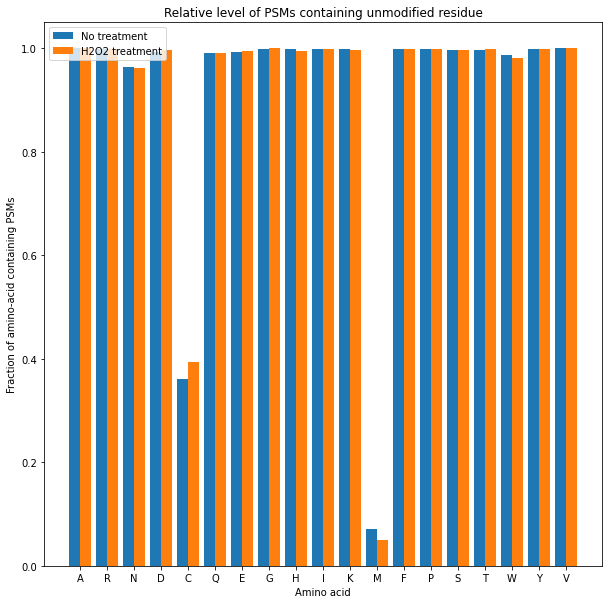

In [63]:
x = RPM["Amino acid"]
xnone = RPM["Relative level of PSMs containing unmodified residue_Control"]
xH = RPM['Relative level of PSMs containing unmodified residue_H2O2']
x_axis = np.arange(len(x))

plt.bar(x_axis - 0.2, xnone, 0.4, label = 'No treatment')
plt.bar(x_axis + 0.2, xH, 0.4, label = 'H2O2 treatment')

plt.xticks(x_axis, x)
plt.xlabel("Amino acid")
plt.ylabel("Fraction of amino-acid containing PSMs")
plt.title("Relative level of PSMs containing unmodified residue")
plt.rcParams["figure.figsize"] = (8,8)
plt.legend()
plt.show()

In [55]:
def methionine_overview(df, ax = None, **kwargs):
    ax = ax or plt.gca()
    filtered = df[df["matched_peptide"].str.contains("M")]
    non_modified = 0
    met_sulfoxide = 0
    met_sulfone = 0
    for index, row in filtered.iterrows():
                peptidoform = row['Peptidoform_name']
                modifications = row['Modification']
                if modifications == None:
                    non_modified += 1
                elif type(modifications) == str:
                    if modifications == "[35]oxidation[M]":
                        met_sulfoxide += 1
                    elif modifications == "[425]Dioxidation[M]":
                        met_sulfone += 1
                elif type(modifications) == list:
                    for mod in modifications:
                        if modifications == "[35]oxidation[M]":
                            met_sulfoxide += 1
                        elif modifications == "[425]Dioxidation[M]":
                            met_sulfone += 1

    labels = ["Met", "Met Sulfoxide", "Met Sulfone"]
    sizes = [non_modified, met_sulfoxide, met_sulfone]
    #ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow= True, startangle = 90)
    # fig1, ax1 = plt.subplots()
    # ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
    #         shadow=True, startangle=90)
    # ax1.axis('equal')  
    # fig1.set_size_inches(8,8)
    # plt.title("Methionine containing peptides", y = 1.08)
    return ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow= True, startangle = 90)

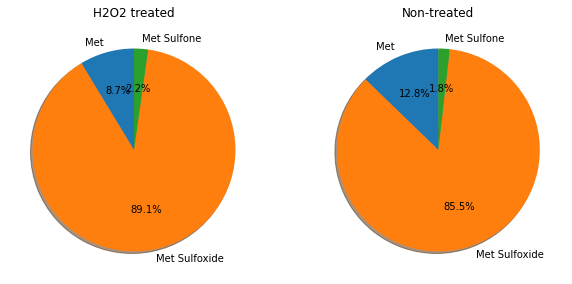

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2)
methionine_overview(H2O2rep, ax1)
methionine_overview(Controlrep, ax2)
plt.title("Methionine containing peptides")
ax1.set_title("H2O2 treated")
ax2.set_title("Non-treated")
plt.show()